We have Diabetes Dataset. Let's look at the dataset's columns and story.

**Dataset** is part of a large dataset maintained at the National Institute of Diabetes and Digestive and Kidney Diseases in the United States. The data is used for a diabetes study conducted on Pima Indian women aged 21 and over, residing in Phoenix, the fifth-largest city in the state of Arizona, USA. The target variable is indicated as **"outcome,"** where **1** denotes a **positive** diabetes test result, and **0** indicates a **negative** result.


* Pregnancies: number of pregnancies
* Glucose: 2-hour plasma glucose concentration in oral glucose tolerance test
* Blood Pressure: Blood Pressure (Diastolic)(mm Hg)
* SkinThickness: Skin Thickness
* Insulin: 2-hour serum insulin (mu U/ml)
* DiabetesPedigreeFunction: Function (2-hour plasma glucose concentration in oral glucose tolerance test)
* BMI: Body Mass Index
* Age: Age (year)
* Outcome: Having the disease (1) or not (0)

First, we need to import libraries.

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-data/diabetes.csv


In [75]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

Loading the dataset:

In [76]:
df = pd.read_csv("/kaggle/input/diabetes-data/diabetes.csv")

In [77]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


### Task 1: Exploratory Data Analysis (EDA)

#### Step 1: The General Image 

In [78]:
def check_df(dataframe, head=5):
    print("####################### Shape #######################")
    print(dataframe.shape)
    print("####################### Types #######################")
    print(dataframe.dtypes)
    print("####################### Head #######################")
    print(dataframe.head(head))
    print("####################### Tails #######################")
    print(dataframe.tail(head))
    print("####################### NA #######################")
    print(dataframe.isnull().sum())
    print("####################### Info #######################")
    print(df.info())
    print("####################### Quantiles #######################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [79]:
check_df(df)

####################### Shape #######################
(768, 9)
####################### Types #######################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
####################### Head #######################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             2

In [80]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Step 2: Capture the numerical and categorical variables

In [82]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [83]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [84]:
print(cat_cols, num_cols, cat_but_car)

['Outcome'] ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] []


/tmp/ipykernel_47/2376031042.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.loc[:,num_cols].hist(ax=ax, bins=50)


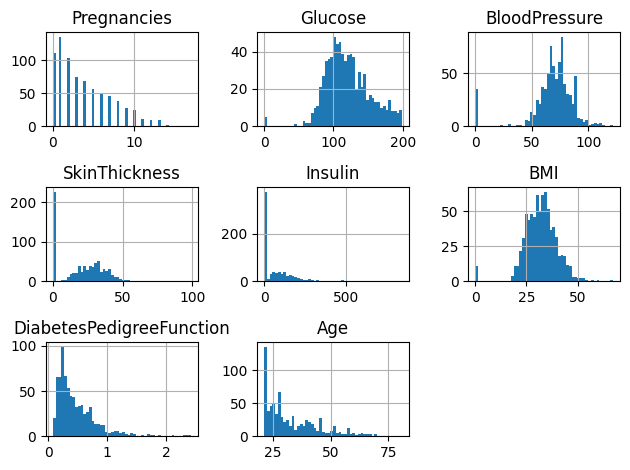

In [85]:
fig, ax = plt.subplots()
df.loc[:,num_cols].hist(ax=ax, bins=50)
fig.tight_layout()
plt.show()

#### Step 3: Perform an analysis of numerical and categorical variables.

Categorical variables:

In [86]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "ratio": 100*dataframe[col_name].value_counts()/len(dataframe)}))
    print("#######")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block = True)

         Outcome  ratio
Outcome                
0            500 65.104
1            268 34.896
#######
         Outcome  ratio
Outcome                
0            500 65.104
1            268 34.896
#######


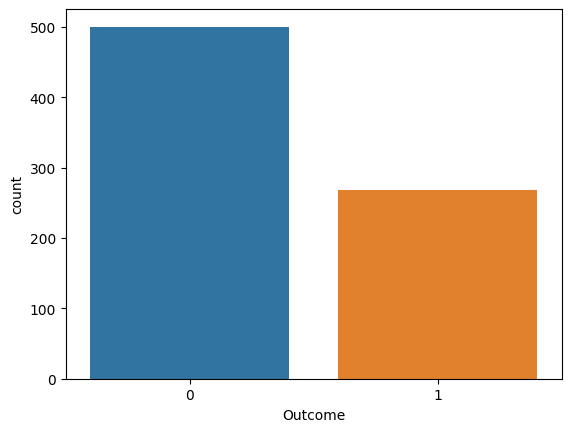

In [87]:
cat_summary(df, "Outcome")

cat_summary(df, "Outcome", plot=True)

Numerical variables:

In [88]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[[numerical_col]].describe(quantiles).T, end="\n\n")
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True) #block=True olduğunda grafikleri üst üste değil, arka arkaya çıkarır



              count  mean   std   min    5%   10%   20%   30%   40%   50%   60%   70%   80%   90%    95%    99%    max
Pregnancies 768.000 3.845 3.370 0.000 0.000 0.000 1.000 1.000 2.000 3.000 4.000 5.000 7.000 9.000 10.000 13.000 17.000



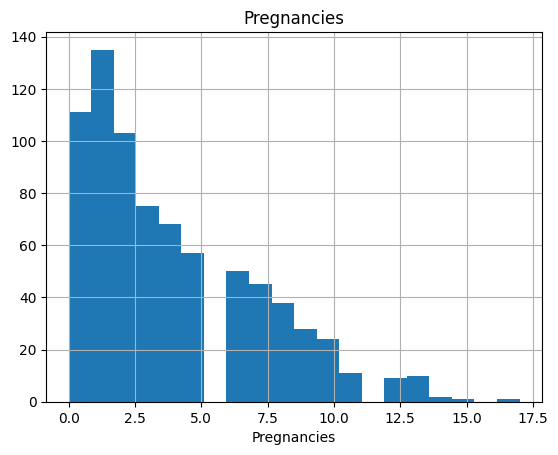

          count    mean    std   min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
Glucose 768.000 120.895 31.973 0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000



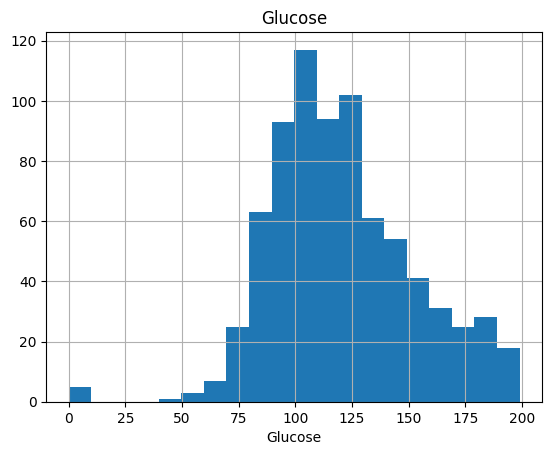

                count   mean    std   min     5%    10%    20%    30%    40%    50%    60%    70%    80%    90%    95%     99%     max
BloodPressure 768.000 69.105 19.356 0.000 38.700 54.000 60.000 64.000 68.000 72.000 74.000 78.000 82.000 88.000 90.000 106.000 122.000



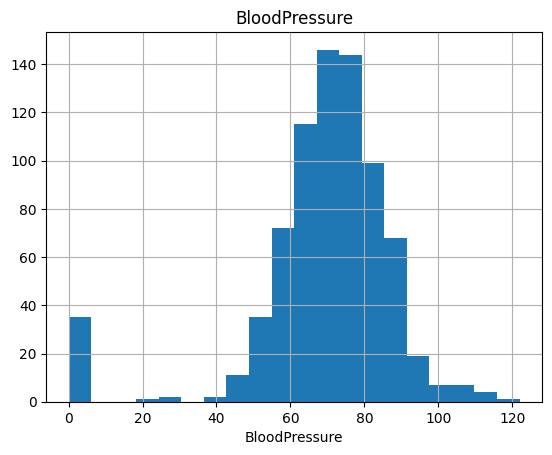

                count   mean    std   min    5%   10%   20%   30%    40%    50%    60%    70%    80%    90%    95%    99%    max
SkinThickness 768.000 20.536 15.952 0.000 0.000 0.000 0.000 8.200 18.000 23.000 27.000 31.000 35.000 40.000 44.000 51.330 99.000



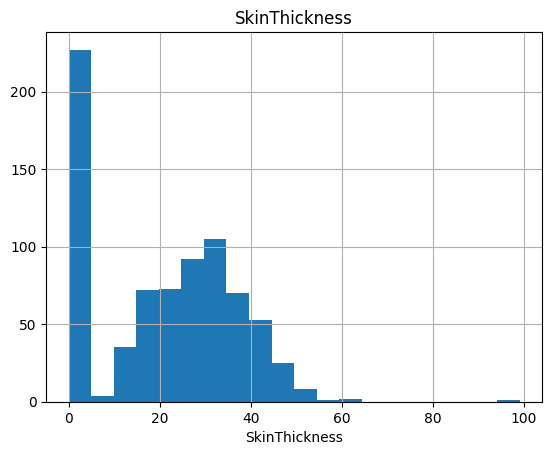

          count   mean     std   min    5%   10%   20%   30%   40%    50%    60%     70%     80%     90%     95%     99%     max
Insulin 768.000 79.799 115.244 0.000 0.000 0.000 0.000 0.000 0.000 30.500 72.200 106.000 150.000 210.000 293.000 519.900 846.000



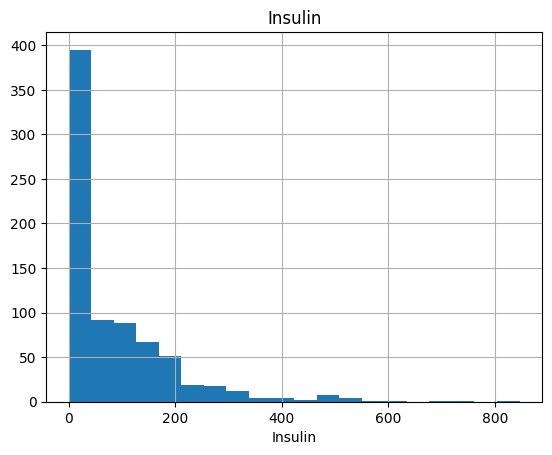

      count   mean   std   min     5%    10%    20%    30%    40%    50%    60%    70%    80%    90%    95%    99%    max
BMI 768.000 31.993 7.884 0.000 21.800 23.600 25.900 28.200 30.100 32.000 33.700 35.490 37.800 41.500 44.395 50.759 67.100



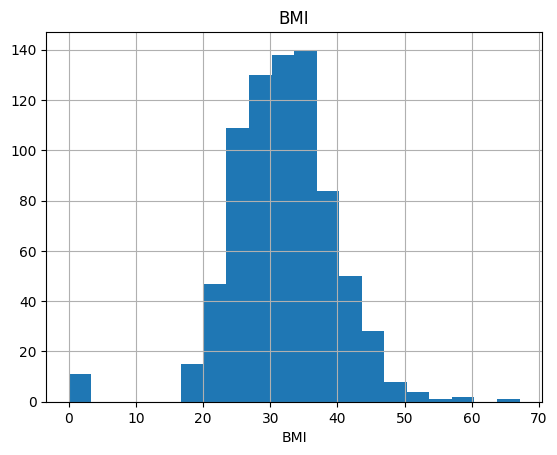

                           count  mean   std   min    5%   10%   20%   30%   40%   50%   60%   70%   80%   90%   95%   99%   max
DiabetesPedigreeFunction 768.000 0.472 0.331 0.078 0.140 0.165 0.219 0.259 0.303 0.372 0.454 0.564 0.687 0.879 1.133 1.698 2.420



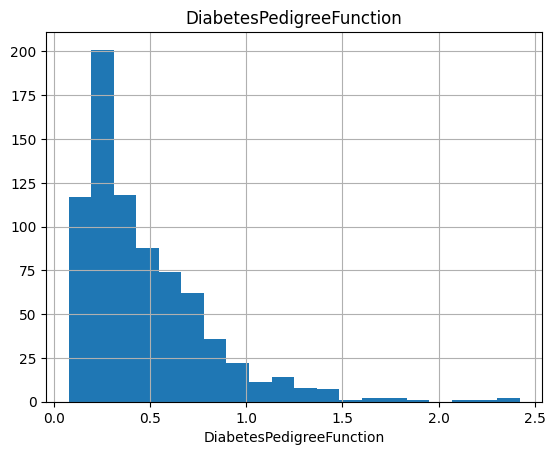

      count   mean    std    min     5%    10%    20%    30%    40%    50%    60%    70%    80%    90%    95%    99%    max
Age 768.000 33.241 11.760 21.000 21.000 22.000 23.000 25.000 27.000 29.000 33.000 38.000 42.600 51.000 58.000 67.000 81.000



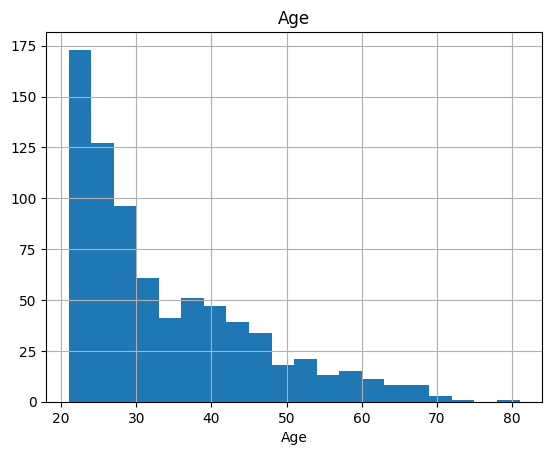

In [89]:
for col in num_cols:
    num_summary(df, col, plot=True)

#### Step 4: Conduct target variable analysis.

In [90]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")


In [91]:

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866

         Glucose
Outcome         
0        109.980
1        141.257

         BloodPressure
Outcome               
0               68.184
1               70.825

         SkinThickness
Outcome               
0               19.664
1               22.164

         Insulin
Outcome         
0         68.792
1        100.336

           BMI
Outcome       
0       30.304
1       35.143

         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550

           Age
Outcome       
0       31.190
1       37.067



#### Step 5: Correlation 

In [92]:
corr = df[num_cols].corr()

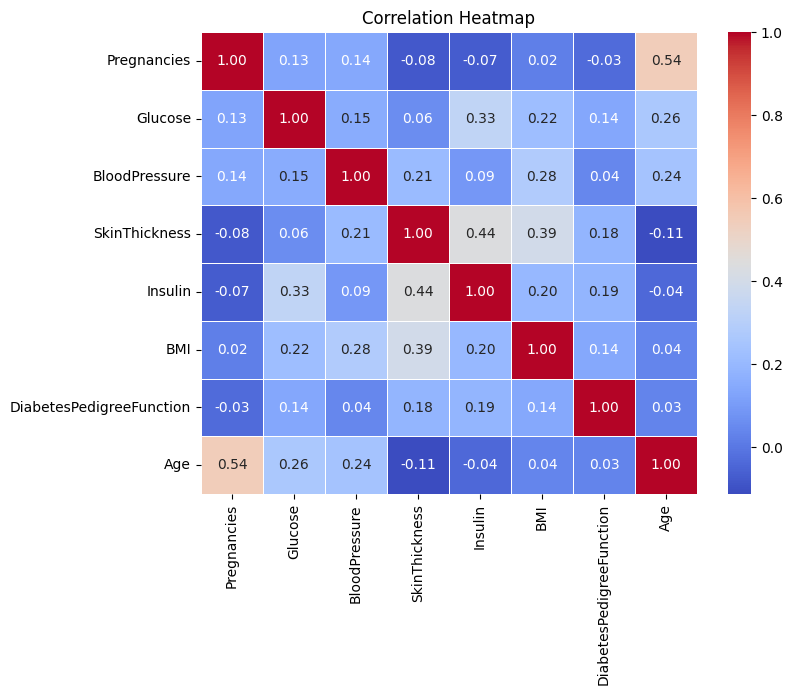

In [93]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show(block=True)

### Task 2: Feature Engineering

#### Step 1: Missing Value Analysis

In [94]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]


In [95]:
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [96]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [97]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


In [98]:
na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


#### Step 2: Examination of the Relationship Between Missing Values and the Dependent Variable

In [99]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "COUNT": temp_df.groupby(col)[target].count()}), end="\n\n\n")



In [100]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  COUNT
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  COUNT
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  COUNT
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  COUNT
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  COUNT
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [101]:
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()



In [102]:

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Step 4: Outliers Analysis

First, we need to determine IQR. 

In [103]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

Then, we investigate whether there are any outliers.

In [104]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None)

We look the above and below the thresholds. If there are any value bigger and smaller than the thresholds, then we replace the thresholds. 

In [105]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [106]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [107]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


#### Step 5: Feature Extraction
In this step, we are going to create variables.

For **BMI**, below 18.5 is considered underweight, between 18.5 and 24.9 is normal, between 24.9 and 29.9 is overweight, and 30 and above is considered obese.

In [108]:
df['BMI'].max()
df['NEW_BMI_CAT'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [109]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_BMI_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Obese
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Overweight
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Healthy
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Obese


For **Age**, between 21 and 50 is mature, 50 and above is senior.

In [110]:
df["Age"].min(),df["Age"].max()
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [111]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_BMI_CAT,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Obese,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Overweight,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Healthy,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Overweight,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Obese,mature


In [112]:
df.columns = [col.upper() for col in df.columns]

In [113]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_BMI_CAT,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Obese,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Overweight,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Healthy,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Overweight,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Obese,mature


We need to perform the separation process based on the types of variables.

In [114]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 11
cat_cols: 3
num_cols: 8
cat_but_car: 0
num_but_cat: 2


#### Step 6: Encoding
We are proceeding with feature engineering. We are going to use label and one-hot encoder for this problem.

In [115]:
# Label Encoding
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [116]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT']

In [117]:
for col in binary_cols:
    df = label_encoder(df, col)

For one-hot encoding, we need to upload the cat_cols list. 

In [118]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_BMI_CAT']

In [119]:
#One-Hot Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [120]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [121]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT_Healthy,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Obese
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,False,False,True
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,False,True,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,True,False,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,False,True,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,False,False,True


#### Step 7: Scaling

In [122]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [123]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT_Healthy,NEW_BMI_CAT_Overweight,NEW_BMI_CAT_Obese
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,False,False,True
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,False,True,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,True,False,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,False,True,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,False,False,True


In [124]:
df.shape

(768, 13)

#### Step 8: Modelling
Lastly, we are going to build a model for this data set.

In [125]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [127]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [128]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.78
Recall: 0.712
Precision: 0.64
F1: 0.68
Auc: 0.76
